## Mini-Project: W4_D5

Your task is to use the Heart Disease UCI dataset to predict whether or not a patient has heart disease based on various medical attributes.

1. Data Preparation:

    Download the “Heart Disease UCI” dataset.
    Perform exploratory data analysis (EDA) to understand the dataset.
    Preprocess the data: handle missing values if any, encode categorical variables, and scale the features.

2. Model Training:

    Split the dataset into a training set and a testing set.
    Train a logistic regression model on the training set.

3. Model Evaluation:

    Evaluate the model on the testing set using accuracy, precision, recall, and F1 score.
    Use a confusion matrix to visualize the model’s performance.


Expected Deliverables

A Jupyter Notebook containing:

- The EDA and preprocessing steps.
- The code for training and evaluating the logistic regression model.
- A confusion matrix and classification report for model evaluation.
- Any visualizations that helped you understand the dataset and the model’s performance.

### Predicting Heart Disease

#### Step 1: Importing Libraries

In [5]:
# Import essential libraries for data manipulation, visualization, and modeling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from IPython.display import display
from collections import Counter

#### Step 2: Data Loading and Initial Inspection

In [6]:
# Load the dataset
df = pd.read_csv("heart_disease_uci.csv")

# Display the first few rows
df.head()

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


**Dataset Overview**

- 920 rows, 16 columns
- Heterogeneous data: numeric features (age, chol, oldpeak) and categorical features (sex, cp, thal, etc.)

#### Step 3: Missing Values Analysis

In [7]:
# Check missing values per column
df.isnull().sum().sort_values(ascending=False)

ca          611
thal        486
slope       309
fbs          90
oldpeak      62
trestbps     59
exang        55
thalch       55
chol         30
restecg       2
cp            0
dataset       0
id            0
age           0
sex           0
num           0
dtype: int64

**Notable missing values:**

- `ca`: 611 missing
- `thal`: 486 missing
- `slope`: 309 missing
- Other columns such as `fbs`, `oldpeak`, `trestbps`, and `chol` have some missing values

In [8]:
df["num"].value_counts().sort_index()

num
0    411
1    265
2    109
3    107
4     28
Name: count, dtype: int64

**Target distribution (`num` column):**

- Class 0: 411 samples (healthy)
- Class 1: 265 samples
- Class 2: 109 samples
- Class 3: 107 samples
- Class 4: 28 samples

**Interpretation:**
There is a strong class imbalance. Class 0 represents almost half of the dataset, while class 4 is very rare. This imbalance may negatively impact multiclass model performance.

#### Step 4: Dropping Columns with Excessive Missing Values

In [9]:
# Calculate the number of missing values per column, sorted in descending order
missing_data = df.isnull().sum().sort_values(ascending=False)

# Define a threshold: drop any column with more than 200 missing values
cols_to_drop = missing_data[missing_data > 200].index.tolist()

# Remove the identified columns from the dataset
df_cleaned = df.drop(columns=cols_to_drop)

# Display the names of the dropped columns
print("Dropped columns:", cols_to_drop)

# Display information about the remaining columns in the cleaned dataset
df_cleaned.info()

Dropped columns: ['ca', 'thal', 'slope']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  num       920 non-null    int64  
dtypes: float64(4), int64(3), object(6)
memory usage: 93.6+ KB


**Explanation:**
Columns with more than 200 missing values were removed to avoid introducing excessive bias through imputation. The remaining dataset has fewer columns but retains most of the available information.

**Interpretation:**
This cleaning step simplifies the dataset while maintaining data integrity. Columns such as `ca`, `thal`, and `slope` were dropped because they contained too many missing records.

#### Step 5: Filling Remaining Missing Values

In [10]:
# Separate numeric and categorical columns
num_cols = df_cleaned.select_dtypes(include=['float64', 'int64']).columns.tolist()
cat_cols = df_cleaned.select_dtypes(include=['object', 'bool']).columns.tolist()

# Create a copy of the cleaned DataFrame
df_filled = df_cleaned.copy()

# Enable future behavior to avoid FutureWarning
pd.set_option('future.no_silent_downcasting', True)

# Fill numeric columns with the mean value
for col in num_cols:
    if df_filled[col].isnull().sum() > 0:
        df_filled[col] = df_filled[col].fillna(df_filled[col].mean())

# Fill categorical columns with the most frequent category (mode)
for col in cat_cols:
    if df_filled[col].isnull().sum() > 0:
        df_filled[col] = df_filled[col].fillna(df_filled[col].mode()[0])

# Convert object columns to appropriate types
df_filled = df_filled.infer_objects(copy=False)

# Final check for any remaining missing values
print("Remaining missing values:")
print(df_filled.isnull().sum()[df_filled.isnull().sum() > 0])

Remaining missing values:
Series([], dtype: int64)


**Explanation:**
- Numeric columns were filled with their mean values.
- Categorical columns were filled with the most frequent category (mode).
- The `infer_objects()` function ensures that object columns are properly converted to appropriate types (e.g., boolean or string), which prevents future warnings.

**Interpretation:**
At this point, there are no missing values left in the dataset. All variables are clean and ready for encoding.

The check confirms this with an empty Series, meaning no columns contain null values anymore.

#### Step 6: Feature Encoding

In [11]:
# Drop the 'dataset' column (not relevant)
df_encoded = df_filled.drop(columns=['dataset'])

# One-Hot Encode categorical columns
df_encoded = pd.get_dummies(
    df_encoded,
    columns=['sex', 'cp', 'fbs', 'restecg', 'exang'],
    drop_first=True
)

# Display resulting columns
print("Encoded columns:", df_encoded.columns.tolist())

Encoded columns: ['id', 'age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'num', 'sex_Male', 'cp_atypical angina', 'cp_non-anginal', 'cp_typical angina', 'fbs_True', 'restecg_normal', 'restecg_st-t abnormality', 'exang_True']


In this step:
Categorical variables are encoded into binary indicators.

drop_first=True avoids multicollinearity by dropping the reference category.

Interpretation:
All features are now numeric, ready for modeling.

#### Step 7: Creating Binary and Multiclass Targets

In [12]:
# Create binary target: 0 = healthy, 1 = diseased
df_encoded['target_bin'] = df_encoded['num'].apply(lambda x: 0 if x == 0 else 1)

# Create multiclass target
df_encoded['target_multi'] = df_encoded['num']

# Define feature set
X = df_encoded.drop(columns=['id', 'num', 'target_bin', 'target_multi'])

# Define targets
y_bin = df_encoded['target_bin']
y_multi = df_encoded['target_multi']

# Display the list of explanatory variables
print("Explanatory variables (X):")
print(X.columns.tolist())

# Display binary target distribution
print("\nBinary target distribution:")
print(y_bin.value_counts())

# Display multiclass target distribution
print("\nMulticlass target distribution:")
print(y_multi.value_counts().sort_index())

Explanatory variables (X):
['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'sex_Male', 'cp_atypical angina', 'cp_non-anginal', 'cp_typical angina', 'fbs_True', 'restecg_normal', 'restecg_st-t abnormality', 'exang_True']

Binary target distribution:
target_bin
1    509
0    411
Name: count, dtype: int64

Multiclass target distribution:
target_multi
0    411
1    265
2    109
3    107
4     28
Name: count, dtype: int64


**Features and target distributions:**

- **Explanatory variables (`X`):**
  ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'sex_Male', 'cp_atypical angina', 'cp_non-anginal', 'cp_typical angina', 'fbs_True', 'restecg_normal', 'restecg_st-t abnormality', 'exang_True']

- **Binary target distribution (`target_bin`):**
  - 0 (healthy): 411 samples
  - 1 (diseased): 509 samples

- **Multiclass target distribution (`target_multi`):**
  - 0: 411 samples
  - 1: 265 samples
  - 2: 109 samples
  - 3: 107 samples
  - 4: 28 samples

**Interpretation:**
The binary classification is relatively balanced, with a slightly higher number of diseased cases. In contrast, the multiclass target is highly imbalanced, especially for class 4 (only 28 samples), which may impact the model's ability to correctly predict rare disease stages.

#### Step 8: Splitting Data into Train and Test Sets

In [13]:
# Binary classification split
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
    X, y_bin, test_size=0.2, random_state=42, stratify=y_bin
)

# Multiclass classification split
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(
    X, y_multi, test_size=0.2, random_state=42, stratify=y_multi
)

This step splits the dataset into training and testing sets:

80% training, 20% testing.

Stratified split preserves class distributions.

Interpretation:
This ensures balanced representation of classes in both subsets.

#### Step 9: Feature Scaling

In [14]:
# Initialize the scaler
scaler = StandardScaler()

# Scale binary features
X_train_bin_scaled = scaler.fit_transform(X_train_bin)
X_test_bin_scaled = scaler.transform(X_test_bin)

# Scale multiclass features
X_train_multi_scaled = scaler.fit_transform(X_train_multi)
X_test_multi_scaled = scaler.transform(X_test_multi)

This step applies standard scaling to numeric features:

Mean = 0

Standard deviation = 1

Interpretation:
Scaling improves convergence and performance of logistic regression and other models.

#### Step 10: Logistic Regression (Binary Classification)

In [15]:
# Initialize logistic regression for binary classification
logreg_bin = LogisticRegression(max_iter=1000, random_state=42)

# Train the model
logreg_bin.fit(X_train_bin_scaled, y_train_bin)

# Make predictions
y_pred_bin = logreg_bin.predict(X_test_bin_scaled)

This step trains a logistic regression model to predict healthy vs diseased.

Interpretation:
The model outputs probabilities and class labels for each observation.

#### Step 11: Logistic Regression (Multiclass Classification)

In [16]:
# Initialize logistic regression for multiclass classification
logreg_multi = LogisticRegression(
    max_iter=1000,
    random_state=42
)

# Train the model
logreg_multi.fit(X_train_multi_scaled, y_train_multi)

# Make predictions
y_pred_multi = logreg_multi.predict(X_test_multi_scaled)

This step trains a logistic regression model for multiclass classification (0–4 disease severity).

Interpretation:
Multinomial logistic regression estimates probabilities for each class.

#### Step 12: Evaluation of Logistic Regression Models

In [17]:
# Generate binary classification report as DataFrame
report_bin = classification_report(y_test_bin, y_pred_bin, output_dict=True)
df_report_bin = pd.DataFrame(report_bin).transpose()

# Styled binary classification report
styled_report_bin = df_report_bin.style \
    .background_gradient(subset=['precision', 'recall', 'f1-score'], cmap='Greens') \
    .format({'precision': '{:.2f}', 'recall': '{:.2f}', 'f1-score': '{:.2f}', 'support': '{:.0f}'}) \
    .set_caption('Logistic Regression - Binary Classification Report')

# Binary confusion matrix as DataFrame
conf_matrix_bin_df = pd.DataFrame(
    confusion_matrix(y_test_bin, y_pred_bin),
    index=["Actual 0", "Actual 1"],
    columns=["Predicted 0", "Predicted 1"]
).style \
    .background_gradient(cmap='Blues') \
    .set_caption('Confusion Matrix - Binary Classification')


# Generate multiclass classification report as DataFrame
report_multi = classification_report(y_test_multi, y_pred_multi, output_dict=True)
df_report_multi = pd.DataFrame(report_multi).transpose()

# Styled multiclass classification report
styled_report_multi = df_report_multi.style \
    .background_gradient(subset=['precision', 'recall', 'f1-score'], cmap='Oranges') \
    .format({'precision': '{:.2f}', 'recall': '{:.2f}', 'f1-score': '{:.2f}', 'support': '{:.0f}'}) \
    .set_caption('Logistic Regression - Multiclass Classification Report')

# Multiclass confusion matrix as DataFrame
conf_matrix_multi_df = pd.DataFrame(
    confusion_matrix(y_test_multi, y_pred_multi),
    index=[f"Actual {i}" for i in range(5)],
    columns=[f"Predicted {i}" for i in range(5)]
).style \
    .background_gradient(cmap='Oranges') \
    .set_caption('Confusion Matrix - Multiclass Classification')


# Display all tables
display(
    styled_report_bin,
    conf_matrix_bin_df,
    styled_report_multi,
    conf_matrix_multi_df
)

,precision,recall,f1-score,support
0,0.84,0.74,0.79,82
1,0.81,0.88,0.85,102
accuracy,0.82,0.82,0.82,1
macro avg,0.82,0.81,0.82,184
weighted avg,0.82,0.82,0.82,184


,Predicted 0,Predicted 1
Actual 0,61,21
Actual 1,12,90


,precision,recall,f1-score,support
0,0.79,0.84,0.82,82
1,0.43,0.55,0.48,53
2,0.38,0.14,0.20,22
3,0.10,0.10,0.10,21
4,0.00,0.00,0.00,6
accuracy,0.56,0.56,0.56,1
macro avg,0.34,0.32,0.32,184
weighted avg,0.53,0.56,0.54,184


,Predicted 0,Predicted 1,Predicted 2,Predicted 3,Predicted 4
Actual 0,69,9,1,3,0
Actual 1,15,29,1,7,1
Actual 2,1,13,3,5,0
Actual 3,2,14,3,2,0
Actual 4,0,2,0,4,0


**Interpretation:**

**Binary Classification:**
- The model achieved **82% accuracy**.
- High recall for diseased cases (**0.88**), which is essential in medical diagnosis.
- The confusion matrix shows few false negatives (12) and balanced performance across classes.

**Multiclass Classification:**
- Class 0 (healthy) is predicted accurately.
- Classes 1–4 have much lower precision and recall.
- The overall accuracy is **56%**, reflecting difficulty distinguishing disease stages, especially rare classes.

**Summary:**
- Binary classification is reliable for detecting disease presence.
- Multiclass classification needs improvement (class weighting, more data, or combining rare classes).

#### Step 13: Confusion Matrices Visualization

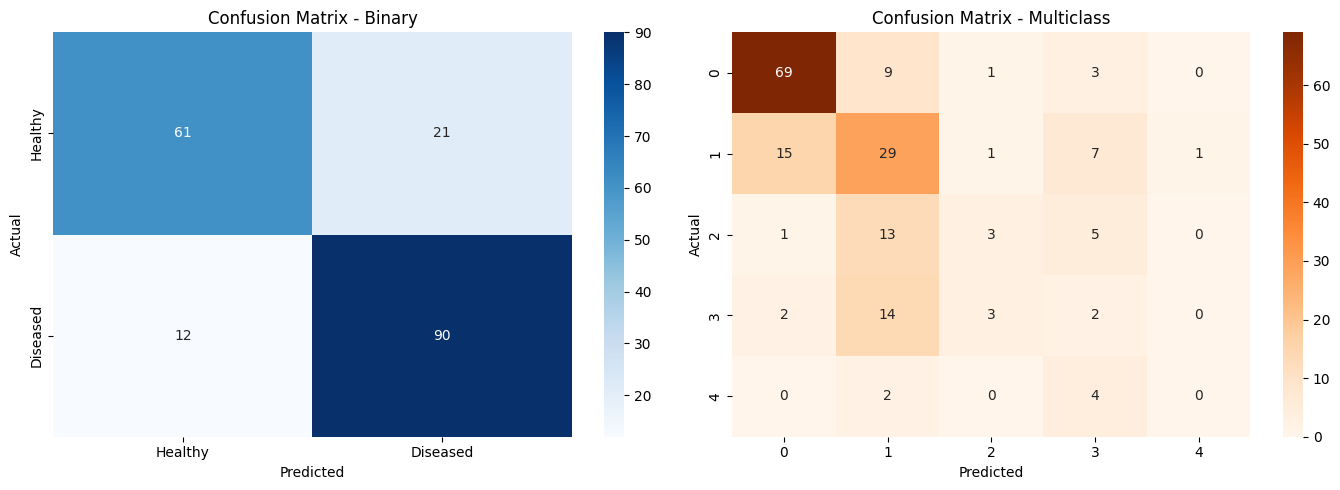

In [18]:
# Configure figure size
plt.rcParams.update({'figure.figsize': (6, 4)})

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Binary confusion matrix
conf_bin = confusion_matrix(y_test_bin, y_pred_bin)
sns.heatmap(conf_bin, annot=True, fmt='d', cmap='Blues', ax=axs[0])
axs[0].set_title('Confusion Matrix - Binary')
axs[0].set_xlabel('Predicted')
axs[0].set_ylabel('Actual')
axs[0].set_xticklabels(['Healthy', 'Diseased'])
axs[0].set_yticklabels(['Healthy', 'Diseased'])

# Multiclass confusion matrix
conf_multi = confusion_matrix(y_test_multi, y_pred_multi)
sns.heatmap(conf_multi, annot=True, fmt='d', cmap='Oranges', ax=axs[1])
axs[1].set_title('Confusion Matrix - Multiclass')
axs[1].set_xlabel('Predicted')
axs[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

**Interpretation of Confusion Matrices:**

- **Binary Classification (left):**
  - The model correctly identified 90 diseased patients (bottom right) and 61 healthy patients (top left).
  - There were 21 false positives (healthy predicted as diseased) and 12 false negatives (diseased predicted as healthy).
  - The relatively low number of false negatives (12) is positive, since in medical diagnosis it is more critical to avoid missing diseased cases.
  - Overall, the model shows good balance between sensitivity and specificity.

- **Multiclass Classification (right):**
  - Class 0 (healthy) is predicted well, with 69 correct predictions out of 82 (high diagonal value in the top left).
  - Class 1 shows moderate performance with 29 correct predictions but significant confusion with neighboring classes.
  - Classes 2, 3, and 4 are poorly predicted:
    - Class 2 is often confused with classes 1 and 3.
    - Class 3 has very few correct predictions (only 2 out of 21).
    - Class 4 is almost never correctly predicted.
  - This reflects the strong imbalance and overlap between disease severity levels, which makes multiclass classification challenging.

**Summary:**
- The binary model is reliable for distinguishing between healthy and diseased patients.
- The multiclass model struggles to differentiate between severity levels, especially for rare classes (3 and 4).
- To improve multiclass performance, you could:
  - Use models with class weighting (e.g., `class_weight="balanced"`).
  - Experiment with more powerful ensemble methods (Random Forest, Gradient Boosting).
  - Consider grouping rare classes together if appropriate.
  - Collect additional data to improve representation of underrepresented classes.

#### Step 14 – Logistic Regression Coefficients Visualization

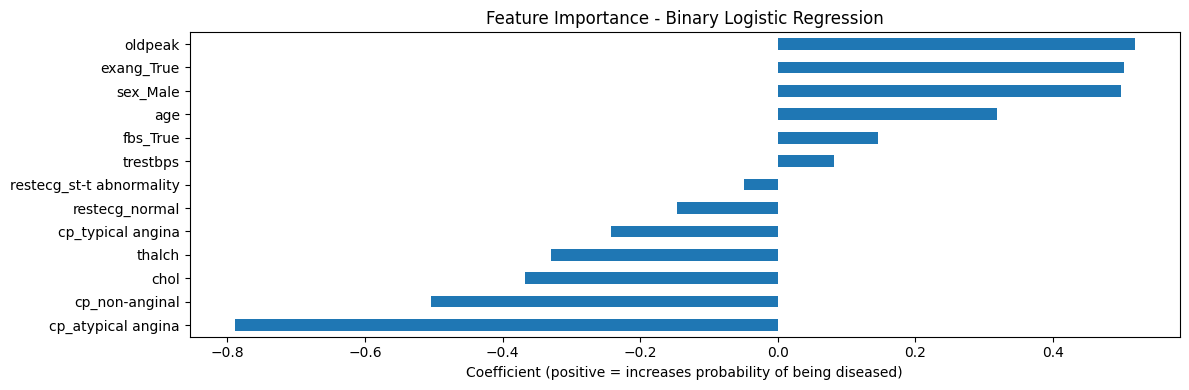

In [19]:
# Create a Series with feature names and their coefficients
coefficients = pd.Series(logreg_bin.coef_[0], index=X.columns)

# Sort coefficients for better visualization
coefficients_sorted = coefficients.sort_values()

# Plot horizontal bar chart
plt.figure(figsize=(12, 4))
coefficients_sorted.plot(kind='barh')
plt.title("Feature Importance - Binary Logistic Regression")
plt.xlabel("Coefficient (positive = increases probability of being diseased)")
plt.tight_layout()
plt.show()

**Interpretation:**

This chart shows the influence of each feature on the probability of being classified as diseased:

- **Positive coefficients** (right side) increase the probability of being diseased:
  - `oldpeak` (ST depression induced by exercise) is the most influential positive predictor.
  - `exang_True` (exercise-induced angina) and `sex_Male` (male gender) also contribute significantly to higher risk.
  - `age` and `fbs_True` (fasting blood sugar >120 mg/dl) have smaller positive contributions.

- **Negative coefficients** (left side) decrease the probability of being diseased:
  - `cp_atypical angina` and `cp_non-anginal` are strongly associated with a lower risk compared to asymptomatic angina.
  - Other negative predictors include `chol` (cholesterol), `thalch` (maximum heart rate achieved), and normal ECG readings.

**Summary:**
Overall, the model gives higher importance to exercise-related indicators (`oldpeak`, `exang_True`) and typical risk factors (age, male sex), while some chest pain types and ECG results are associated with reduced likelihood of disease.

#### Step 15: Random Forest (Binary and Multiclass with Balanced Class Weights)

In [20]:
# Initialize Random Forest models
rf_bin = RandomForestClassifier(n_estimators=100, random_state=42)
rf_multi = RandomForestClassifier(
    n_estimators=100,
    class_weight="balanced",
    random_state=42
)

# Train Random Forest models
rf_bin.fit(X_train_bin_scaled, y_train_bin)
rf_multi.fit(X_train_multi_scaled, y_train_multi)

# Make predictions
y_pred_rf_bin = rf_bin.predict(X_test_bin_scaled)
y_pred_rf_multi = rf_multi.predict(X_test_multi_scaled)

# Generate binary classification report
report_bin = classification_report(y_test_bin, y_pred_rf_bin, output_dict=True)
df_report_bin = pd.DataFrame(report_bin).transpose()

# Styled binary classification report
styled_report_bin = df_report_bin.style \
    .background_gradient(subset=['precision', 'recall', 'f1-score'], cmap='Greens') \
    .format({'precision': '{:.2f}', 'recall': '{:.2f}', 'f1-score': '{:.2f}', 'support': '{:.0f}'}) \
    .set_caption('Random Forest - Binary Classification Report')

# Binary confusion matrix
conf_matrix_bin_df = pd.DataFrame(
    confusion_matrix(y_test_bin, y_pred_rf_bin),
    index=["Actual 0", "Actual 1"],
    columns=["Predicted 0", "Predicted 1"]
).style \
    .background_gradient(cmap='Blues') \
    .set_caption('Random Forest - Confusion Matrix (Binary Classification)')


# Generate multiclass classification report
report_multi = classification_report(y_test_multi, y_pred_rf_multi, output_dict=True)
df_report_multi = pd.DataFrame(report_multi).transpose()

# Styled multiclass classification report
styled_report_multi = df_report_multi.style \
    .background_gradient(subset=['precision', 'recall', 'f1-score'], cmap='Oranges') \
    .format({'precision': '{:.2f}', 'recall': '{:.2f}', 'f1-score': '{:.2f}', 'support': '{:.0f}'}) \
    .set_caption('Random Forest - Multiclass Classification Report')

# Multiclass confusion matrix
conf_matrix_multi_df = pd.DataFrame(
    confusion_matrix(y_test_multi, y_pred_rf_multi),
    index=[f"Actual {i}" for i in range(5)],
    columns=[f"Predicted {i}" for i in range(5)]
).style \
    .background_gradient(cmap='Oranges') \
    .set_caption('Random Forest - Confusion Matrix (Multiclass Classification)')


# Display all tables
display(
    styled_report_bin,
    conf_matrix_bin_df,
    styled_report_multi,
    conf_matrix_multi_df
)

,precision,recall,f1-score,support
0,0.82,0.77,0.79,82
1,0.82,0.86,0.84,102
accuracy,0.82,0.82,0.82,1
macro avg,0.82,0.82,0.82,184
weighted avg,0.82,0.82,0.82,184


,Predicted 0,Predicted 1
Actual 0,63,19
Actual 1,14,88


,precision,recall,f1-score,support
0,0.77,0.80,0.79,82
1,0.45,0.51,0.48,53
2,0.20,0.14,0.16,22
3,0.24,0.24,0.24,21
4,0.50,0.17,0.25,6
accuracy,0.55,0.55,0.55,1
macro avg,0.43,0.37,0.38,184
weighted avg,0.54,0.55,0.54,184


,Predicted 0,Predicted 1,Predicted 2,Predicted 3,Predicted 4
Actual 0,66,9,5,2,0
Actual 1,16,27,4,6,0
Actual 2,3,10,3,6,0
Actual 3,1,12,2,5,1
Actual 4,0,2,1,2,1


**Interpretation:**

**Binary Classification:**
- Accuracy: **82%**, similar to logistic regression.
- High recall (**0.86**) for diseased cases.
- Balanced precision and few false negatives.

**Multiclass Classification:**
- Class 0 predicted well (f1-score ~0.79).
- Other classes have low precision and recall (f1-scores ~0.16–0.48).
- Overall accuracy: **55%**.

**Summary:**
- Random Forest is reliable for binary detection.
- Multiclass prediction remains challenging due to class imbalance.

#### Step 16: Visualize confusion matrices for Random Forest models

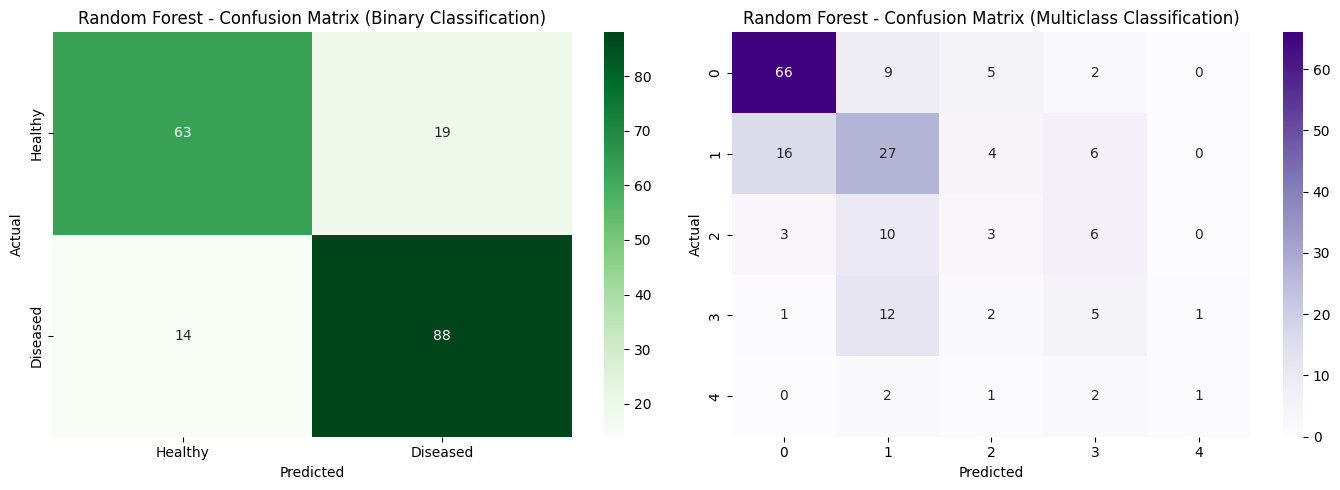

In [21]:
# Create figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Binary confusion matrix
conf_matrix_rf_bin = confusion_matrix(y_test_bin, y_pred_rf_bin)
sns.heatmap(conf_matrix_rf_bin, annot=True, fmt='d', cmap='Greens', ax=axs[0])
axs[0].set_title('Random Forest - Confusion Matrix (Binary Classification)')
axs[0].set_xlabel('Predicted')
axs[0].set_ylabel('Actual')
axs[0].set_xticklabels(['Healthy', 'Diseased'])
axs[0].set_yticklabels(['Healthy', 'Diseased'])

# Multiclass confusion matrix
conf_matrix_rf_multi = confusion_matrix(y_test_multi, y_pred_rf_multi)
sns.heatmap(conf_matrix_rf_multi, annot=True, fmt='d', cmap='Purples', ax=axs[1])
axs[1].set_title('Random Forest - Confusion Matrix (Multiclass Classification)')
axs[1].set_xlabel('Predicted')
axs[1].set_ylabel('Actual')

# Adjust layout
plt.tight_layout()
plt.show()

**Interpretation of Confusion Matrices**

**Binary Classification:**
- **63 true negatives** (healthy correctly predicted).
- **88 true positives** (diseased correctly predicted).
- **19 false positives** (healthy predicted as diseased).
- **14 false negatives** (diseased predicted as healthy).
- Most errors are mild (few false negatives), confirming good reliability for detecting disease presence.

**Multiclass Classification:**
- Class 0 is predicted best, with 66 correct predictions.
- Classes 1, 2, and 3 often get confused with each other (many off-diagonal errors).
- Class 4 is rarely correctly predicted (only 1 correct).
- Overall, the model struggles to separate advanced disease stages due to limited data and class imbalance.

**Summary:**
- Binary classification performs robustly.
- Multiclass classification requires improvement (more data or alternative modeling).

#### Step 15: Evaluation of Random Forest Models

In [22]:
# Binary Classification Report
report_bin = classification_report(y_test_bin, y_pred_rf_bin, output_dict=True)
df_report_bin = pd.DataFrame(report_bin).transpose()

# Multiclass Classification Report
report_multi = classification_report(y_test_multi, y_pred_rf_multi, output_dict=True)
df_report_multi = pd.DataFrame(report_multi).transpose()

# Confusion Matrices
conf_matrix_bin = confusion_matrix(y_test_bin, y_pred_rf_bin)
df_conf_bin = pd.DataFrame(
    conf_matrix_bin,
    index=["Actual 0", "Actual 1"],
    columns=["Predicted 0", "Predicted 1"]
)

conf_matrix_multi = confusion_matrix(y_test_multi, y_pred_rf_multi)
df_conf_multi = pd.DataFrame(
    conf_matrix_multi,
    index=[f"Actual {i}" for i in range(conf_matrix_multi.shape[0])],
    columns=[f"Predicted {i}" for i in range(conf_matrix_multi.shape[1])]
)

# Display styled classification reports
styled_report_bin = df_report_bin.style.background_gradient(cmap="Greens").set_caption("Random Forest - Binary Classification Report")
styled_report_multi = df_report_multi.style.background_gradient(cmap="Purples").set_caption("Random Forest - Multiclass Classification Report")

# Display styled confusion matrices
styled_conf_bin = df_conf_bin.style.background_gradient(cmap="Greens").set_caption("Random Forest - Confusion Matrix (Binary Classification)")
styled_conf_multi = df_conf_multi.style.background_gradient(cmap="Purples").set_caption("Random Forest - Confusion Matrix (Multiclass Classification)")

# Show in notebook
display(styled_report_bin)
display(styled_conf_bin)
display(styled_report_multi)
display(styled_conf_multi)

,precision,recall,f1-score,support
0,0.818182,0.768293,0.792453,82.000000
1,0.822430,0.862745,0.842105,102.000000
accuracy,0.820652,0.820652,0.820652,0.820652
macro avg,0.820306,0.815519,0.817279,184.000000
weighted avg,0.820537,0.820652,0.819978,184.000000


,Predicted 0,Predicted 1
Actual 0,63,19
Actual 1,14,88


,precision,recall,f1-score,support
0,0.767442,0.804878,0.785714,82.000000
1,0.450000,0.509434,0.477876,53.000000
2,0.200000,0.136364,0.162162,22.000000
3,0.238095,0.238095,0.238095,21.000000
4,0.500000,0.166667,0.250000,6.000000
accuracy,0.554348,0.554348,0.554348,0.554348
macro avg,0.431107,0.371088,0.382770,184.000000
weighted avg,0.539023,0.554348,0.542519,184.000000


,Predicted 0,Predicted 1,Predicted 2,Predicted 3,Predicted 4
Actual 0,66,9,5,2,0
Actual 1,16,27,4,6,0
Actual 2,3,10,3,6,0
Actual 3,1,12,2,5,1
Actual 4,0,2,1,2,1


#### Random Forest – Model Evaluation Summary

### Binary Classification
- **Overall accuracy: ~82%**
- Balanced performance across classes:
  - **Class 0 (healthy):**
    - Precision ~0.82
    - Recall ~0.77
  - **Class 1 (diseased):**
    - Precision ~0.82
    - Recall ~0.86
- **Confusion matrix highlights:**
  - 63 true negatives
  - 88 true positives
  - 19 false positives (healthy predicted as diseased)
  - 14 false negatives (diseased predicted as healthy)
- The model is reliable for detecting disease.

---

### Multiclass Classification
- **Overall accuracy: ~55%**
- Class performance details:
  - **Class 0:** Precision ~0.77, recall ~0.80 – best detected.
  - **Class 1:** Precision ~0.45, recall ~0.51 – moderate performance.
  - **Classes 2, 3, 4:** Low precision (0.20–0.50) and very low recall (~0.13–0.24).
- **Confusion matrix shows** many misclassifications among intermediate disease stages.

---

### Summary
- **Binary Random Forest:** High performance, comparable to logistic regression.
- **Multiclass Random Forest:** Better than random but struggles to distinguish classes 2, 3, and 4.
- **Potential improvements:**
  - Collect more samples per class.
  - Try alternative models (e.g., gradient boosting).
  - Consider reducing to binary classification if clinically acceptable.

#### Step 16: Visualizing Feature Importances

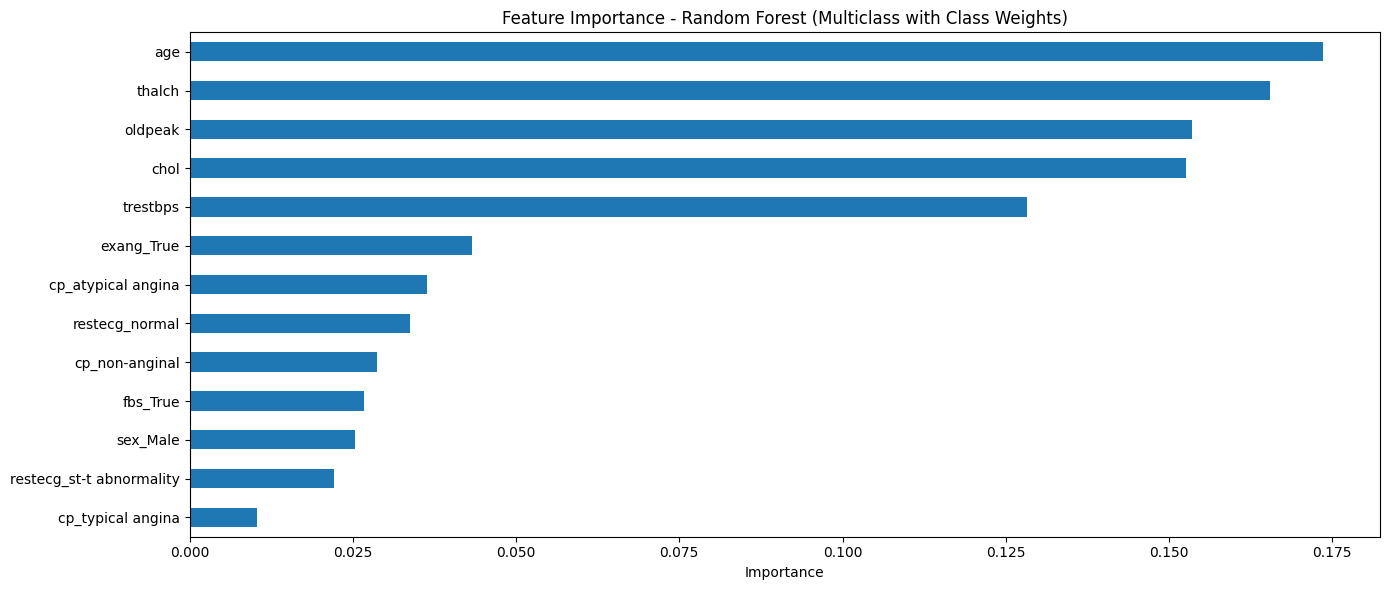

In [23]:
# Plot feature importances from rf_multi
importances = pd.Series(rf_multi.feature_importances_, index=X.columns)
importances_sorted = importances.sort_values(ascending=True)

plt.figure(figsize=(14, 6))
importances_sorted.plot(kind='barh')
plt.title('Feature Importance - Random Forest (Multiclass with Class Weights)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()


#### Feature Importance – Random Forest (Multiclass Classification)

This bar chart shows which variables the Random Forest used most to predict disease classes:

**Top important features:**
- **Age:** Strongest predictor overall.
- **thalch (max heart rate):** Highly relevant for classification.
- **oldpeak:** Depression induced by exercise.
- **chol (cholesterol):** Important risk factor.
- **trestbps (resting blood pressure):** Also influential.

**Moderately important:**
- **exang_True:** Exercise-induced angina.
- **cp_atypical angina:** Type of chest pain.
- **restecg_normal:** Normal ECG readings.

**Less important:**
- **sex_Male, fbs_True, cp_non-anginal:** Some predictive value.
- **restecg_st-t abnormality and cp_typical angina:** Least importance in the model.

**Interpretation:**
The model relies mainly on age, exercise-related variables, cholesterol, and blood pressure. Demographic and certain ECG variables play a smaller role.